In [1]:
!pip install -q transformers

In [2]:
import transformers
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add,Flatten
from tensorflow.keras.layers import Layer, Dense, Embedding
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
#256x256
test_img=cv2.imread("/content/download.jpeg")
test_img=cv2.resize(test_img,(256,256))

In [4]:
patches=tf.image.extract_patches(images=tf.expand_dims(test_img,axis=0),
                                sizes=[1,16,16,1],
                                strides=[1,16,16,1],
                                rates=[1,1,1,1],
                                padding='VALID')

In [5]:
patches.shape #16*16*3=786 because of 3 channels

TensorShape([1, 16, 16, 768])

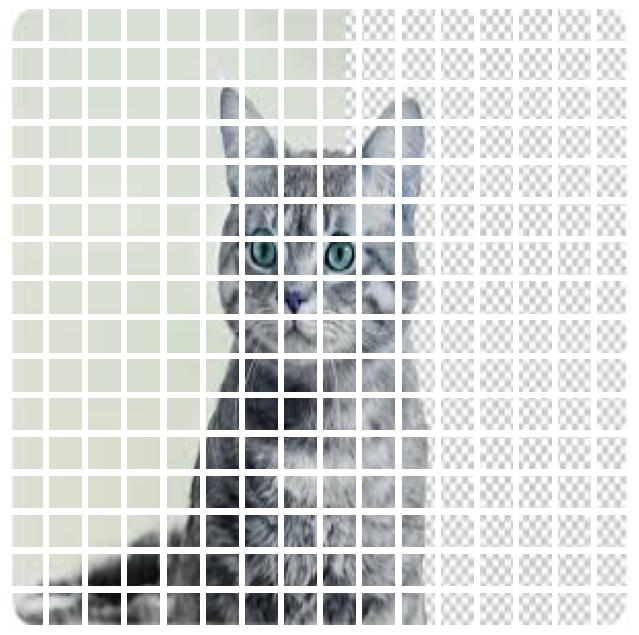

In [6]:
plt.figure(figsize=(8,8))
k=0
for i in range(16):
  for j in range(16):
    ax=plt.subplot(16,16,k+1)
    plt.imshow(tf.reshape(patches[0,i,j,:],(16,16,3)))
    plt.axis("off")
    k=k+1

In [7]:
patches=tf.reshape(patches,(patches.shape[0],256,768))
patches.shape

TensorShape([1, 256, 768])

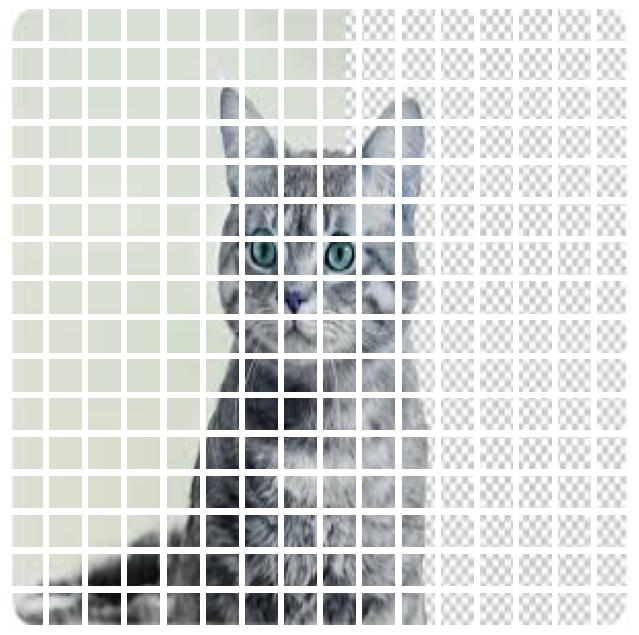

In [8]:
plt.figure(figsize=(8,8))
for i in range(patches.shape[1]):
    ax=plt.subplot(16,16,i+1)
    plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
    plt.axis("off")

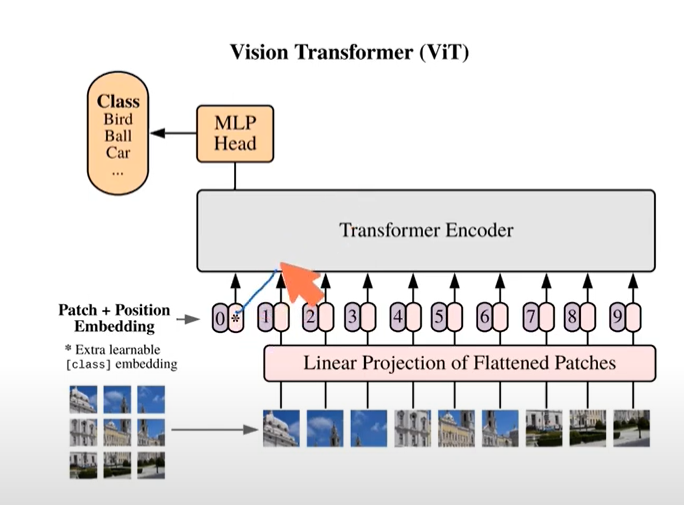

In [9]:
class PatchEncoder(Layer):
  def __init__(self,N_PATCHES,HIDDEN_SIZE):
     super(PatchEncoder,self).__init__(name='patch_encoder')

     self.linear_projection=Dense(HIDDEN_SIZE)
     self.positional_embedding=Embedding(N_PATCHES,HIDDEN_SIZE)#positive integers into dense vector
     self.N_PATCHES=N_PATCHES
  def call(self,x):
     patches=tf.image.extract_patches(images=x,
                                sizes=[1,16,16,1],
                                strides=[1,16,16,1],
                                rates=[1,1,1,1],
                                padding='VALID')
     patches=tf.reshape(patches,(tf.shape(patches)[0],256,patches.shape[-1]))
     embedding_input=tf.range(start=0,limit=self.N_PATCHES,delta=1)
     output=self.linear_projection(patches)+self.positional_embedding(embedding_input)
     return output


In [10]:
patch_enc=PatchEncoder(256,786)
patch_enc(tf.zeros([16,256,256,3]))#dummy image

<tf.Tensor: shape=(16, 256, 786), dtype=float32, numpy=
array([[[-0.00298885,  0.00033387, -0.02756093, ..., -0.02425026,
          0.04093737,  0.02151859],
        [-0.02224525, -0.03490717, -0.01940286, ..., -0.04112637,
          0.04348309, -0.00108488],
        [-0.03925736,  0.01892134, -0.03602945, ..., -0.00676837,
          0.04768516,  0.00909745],
        ...,
        [-0.0281581 ,  0.00223645, -0.00665363, ...,  0.04694455,
         -0.03642334,  0.04794376],
        [-0.0004547 , -0.00045568, -0.04810263, ...,  0.02401641,
         -0.00495915,  0.00840737],
        [ 0.03883601, -0.01596363, -0.04839658, ...,  0.03347913,
         -0.02908523, -0.04655805]],

       [[-0.00298885,  0.00033387, -0.02756093, ..., -0.02425026,
          0.04093737,  0.02151859],
        [-0.02224525, -0.03490717, -0.01940286, ..., -0.04112637,
          0.04348309, -0.00108488],
        [-0.03925736,  0.01892134, -0.03602945, ..., -0.00676837,
          0.04768516,  0.00909745],
        ...

Linear Projection Done

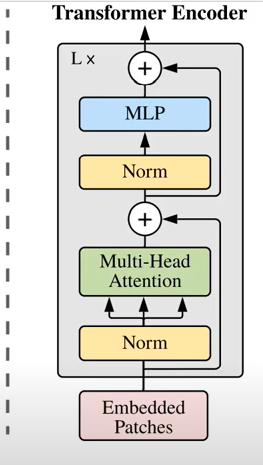

In [11]:
# Transformer
class TransformerEncoder(Layer):
  def __init__(self,N_HEADS,HIDDEN_SIZE):
     super(TransformerEncoder,self).__init__(name='transformer_encoder')

     self.layer_norm_1= LayerNormalization()
     self.layer_norm_2= LayerNormalization()

     self.multi_head_att=MultiHeadAttention(N_HEADS,HIDDEN_SIZE)

     self.dense_1= Dense(HIDDEN_SIZE,activation=tf.nn.gelu)
     self.dense_2= Dense(HIDDEN_SIZE,activation=tf.nn.gelu)

  def call(self,x):
     y=self.layer_norm_1(x)
     y=self.multi_head_att(y,y)
     y=Add()([y,x])
     z=self.layer_norm_2(y)
     z=self.dense_1(z)
     output=self.dense_2(z)
     output=Add()([output,y])
     return output


In [12]:
transformer_enc=TransformerEncoder(8,768)
transformer_enc(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [13]:
class VIT(Model):
  def __init__(self,N_HEADS,HIDDEN_SIZE,N_PATCHES,N_LAYERS,N_DENSE_UNITS):
     super(VIT,self).__init__(name='vision transformer')
     self.N_LAYERS=N_LAYERS
     self.patch_encoder=PatchEncoder(N_PATCHES,HIDDEN_SIZE)
     self.transformer_encoderder=[TransformerEncoder(N_HEADS,HIDDEN_SIZE) for _ in range(N_LAYERS)]
     #MLP HEAD
     self.dense_1= Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
     self.dense_2= Dense(N_DENSE_UNITS,activation=tf.nn.gelu)
     self.dense_3= Dense(3,activation='softmax')

  def call(self,x,training=True):
    x=self.patch_encoder(x)
    for i in range(self.N_LAYERS):
        x= self.transformer_encoderder[i](x)
    x=Flatten()(x)
    x=self.dense_1(x)
    x=self.dense_2(x)


    return self.dense_3(x)

In [14]:
vit=VIT(4,768,256,2,128)
vit(tf.zeros([8,256,256,3]))

<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[0.41864312, 0.28549922, 0.2958576 ],
       [0.41864312, 0.28549922, 0.2958576 ],
       [0.41864312, 0.28549922, 0.2958576 ],
       [0.41864312, 0.28549922, 0.2958576 ],
       [0.41864312, 0.28549922, 0.2958576 ],
       [0.41864312, 0.28549922, 0.2958576 ],
       [0.41864312, 0.2854993 , 0.29585752],
       [0.41864318, 0.28549924, 0.2958576 ]], dtype=float32)>

In [15]:
vit.summary()

Model: "vision transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_8 (Dense)             multiple                  25165952  
                                                                 
 dense_9 (Dense)             multiple                  16512     
                                                

In [16]:
loss_function = 'categorical_crossentropy'
metrics = ['accuracy']
vit.compile(optimizer=Adam(learning_rate=0.001),loss=loss_function,metrics=metrics)

In [17]:
history=vit.fit(train_dataset,validation_dataset,epochs=10,verbose=1)